<a href="https://colab.research.google.com/github/Annemarie535257/Kaggle_Competition/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [14]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [46]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,...,day_of_year,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,is_weekend,is_rush_hour,is_night
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,...,1.0,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025,0.0,0.0,1.0
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,...,1.0,0.258819,0.965926,-0.433884,-0.900969,0.5,0.866025,0.0,0.0,1.0
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,...,1.0,0.500000,0.866025,-0.433884,-0.900969,0.5,0.866025,0.0,0.0,1.0
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,...,1.0,0.707107,0.707107,-0.433884,-0.900969,0.5,0.866025,0.0,0.0,1.0
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,...,1.0,0.866025,0.500000,-0.433884,-0.900969,0.5,0.866025,0.0,0.0,1.0


In [47]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5', 'year', 'month', 'day', 'hour',
       'day_of_week', 'day_of_year', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_rush_hour',
       'is_night'],
      dtype='object')

In [48]:
# Convert datetime and create time features - FIXED VERSION
def create_time_features(df):
    # Convert datetime column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Extract basic time features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear

    # Cyclical encoding for temporal features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Time-based indicators
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) |
                          (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

    return df

# Apply to both datasets
print("Creating time features...")
train = create_time_features(train)
test = create_time_features(test)

print("✅ Time features created successfully!")
print(f"Train shape after feature engineering: {train.shape}")


Creating time features...
✅ Time features created successfully!
Train shape after feature engineering: (30676, 27)


# DATA ANALYSIS AND VISUALIZATION

/tmp/ipython-input-1734927687.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='pm2.5', data=train, palette="Greens")


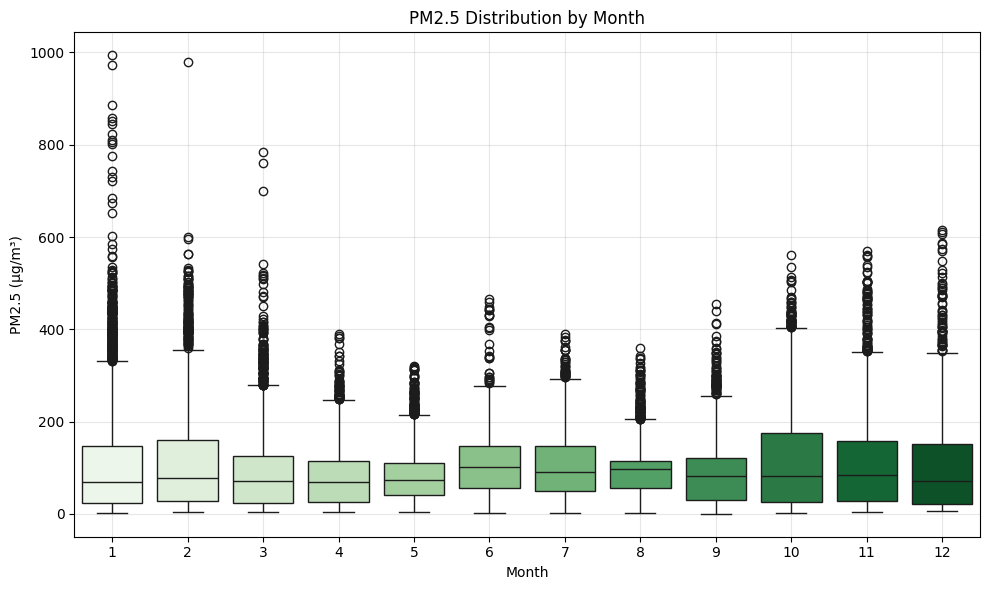

In [49]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='pm2.5', data=train, palette="Greens")
plt.xlabel('Month')
plt.ylabel('PM2.5 (μg/m³)')
plt.title('PM2.5 Distribution by Month')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


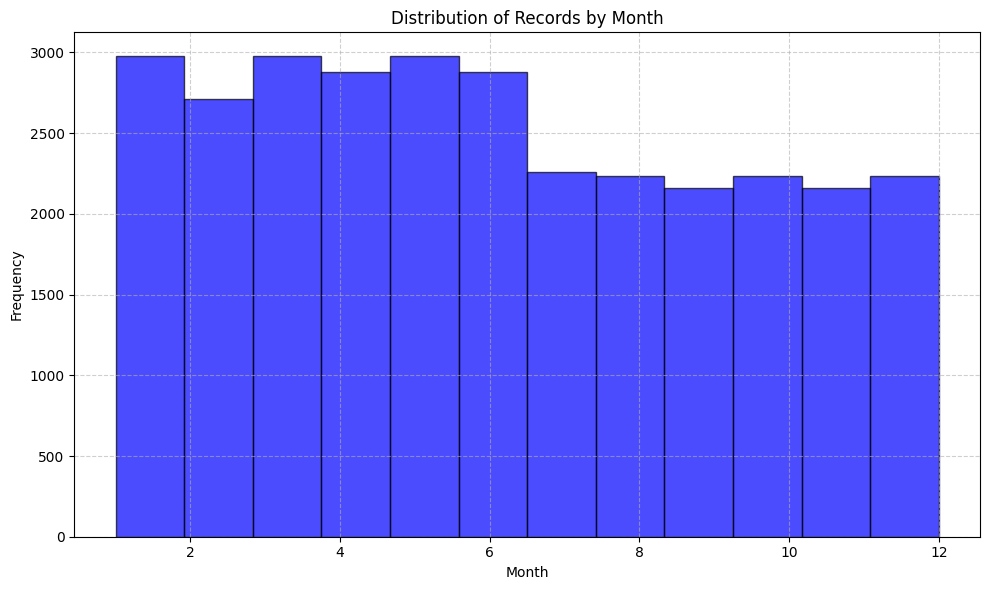

In [50]:
plt.figure(figsize=(10, 6))
plt.hist(train['month'], bins=12, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Records by Month')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


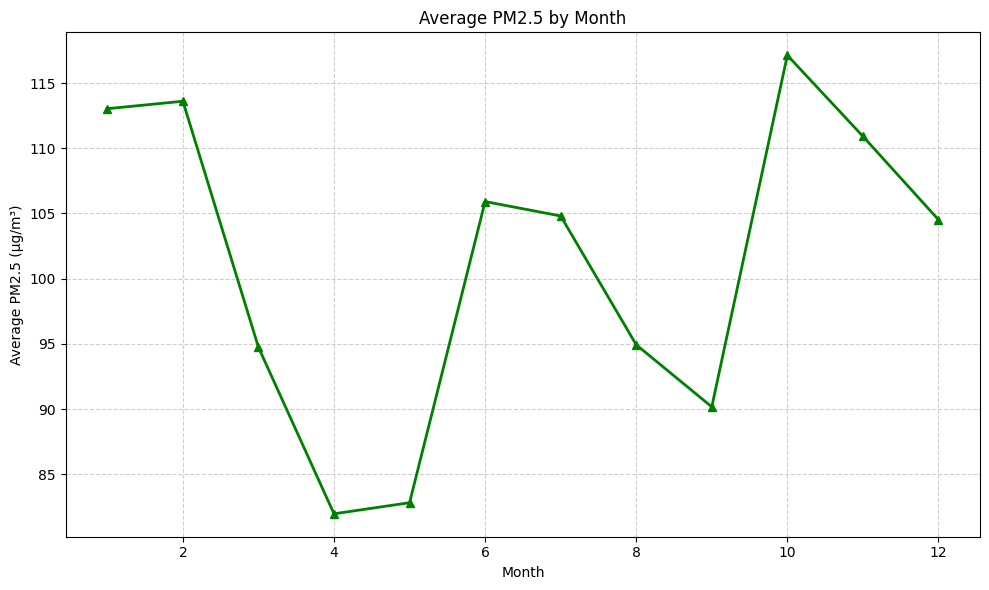

In [51]:
plt.figure(figsize=(10, 6))
month_avg = train.groupby('month')['pm2.5'].mean()

plt.plot(month_avg.index, month_avg.values, marker='^', color='green', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Average PM2.5 (μg/m³)')
plt.title('Average PM2.5 by Month')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [52]:
# Handle missing values with KNN imputation
from sklearn.impute import KNNImputer

print("Handling missing values...")

# Separate features and target
feature_cols = [col for col in train.columns if col not in ['pm2.5', 'datetime', 'No']]
X_train_full = train[feature_cols].copy()
y_train_full = train['pm2.5'].copy()

# KNN imputation
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_train_imputed = imputer.fit_transform(X_train_full)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_cols, index=X_train_full.index)

# Update original dataframe
train[feature_cols] = X_train_imputed
train['pm2.5'] = y_train_full.fillna(y_train_full.mean())


print('✅ Missing values handled with KNN imputation!')
print('Remaining missing values in train:', train.isnull().sum().sum())
print('Remaining missing values in test:', test.isnull().sum().sum())

Handling missing values...
✅ Missing values handled with KNN imputation!
Remaining missing values in train: 0
Remaining missing values in test: 0


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [53]:
# Prepare features and target
print("Preparing features...")

X_train = train[feature_cols]
y_train = train['pm2.5']
X_test = test[feature_cols]

print(f"Feature preparation complete!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Target variable shape: {y_train.shape}")

Preparing features...
Feature preparation complete!
X_train shape: (30676, 24)
y_train shape: (30676,)
X_test shape: (13148, 24)
Target variable shape: (30676,)


In [54]:
# Scale the features
from sklearn.preprocessing import StandardScaler, RobustScaler

# Scale features
print("Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled successfully!")
print(f"Scaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")
print(f"Scaled train range: {X_train_scaled.min():.2f} to {X_train_scaled.max():.2f}")

# Reshape data for LSTM
print("Reshaping data for LSTM...")

# Reshape for LSTM: (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

print(f"✅ Data reshaped for LSTM!")
print(f"Train reshaped shape: {X_train_reshaped.shape}")
print(f"Test reshaped shape: {X_test_reshaped.shape}")
print(f"Input shape for LSTM: ({X_train_reshaped.shape[1]}, {X_train_reshaped.shape[2]})")

Scaling features...
✅ Features scaled successfully!
Scaled train shape: (30676, 24)
Scaled test shape: (13148, 24)
Scaled train range: -2.48 to 32.58
Reshaping data for LSTM...
✅ Data reshaped for LSTM!
Train reshaped shape: (30676, 1, 24)
Test reshaped shape: (13148, 1, 24)
Input shape for LSTM: (1, 24)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [56]:
# Define the LSTM model (STABLE VERSION - NO NaN issues!)
print("Defining LSTM model...")

model = Sequential([
    # First LSTM layer with return_sequences for stacking
    LSTM(64, activation="tanh", return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),

    # Second LSTM layer
    LSTM(32, activation="tanh"),
    Dropout(0.2),

    # Dense layers
    Dense(32, activation="relu"),
    Dropout(0.1),
    Dense(1, activation="linear")
])

# Compile the model with stable settings
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Conservative learning rate
    loss="mse",
    metrics=["mae"]
)

print("✅ Model defined successfully!")
print(f"Model parameters: {model.count_params():,}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

model.summary()

Defining LSTM model...
✅ Model defined successfully!
Model parameters: 36,289
Input shape: (None, 1, 24)
Output shape: (None, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 64)          │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,289 (141.75 KB)

 Trainable params: 36,289 (141.75 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
# Train the model\n
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Train the model
print("🚀 Training the model...")

# Define callbacks for better training
callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6, verbose=1)
]

history = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed successfully!")
print("🎉 No NaN values during training!")


🚀 Training the model...
Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 11645.4668 - mae: 75.3450 - val_loss: 7946.4146 - val_mae: 56.1236 - learning_rate: 0.0010
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 4528.5308 - mae: 45.6288 - val_loss: 5802.3838 - val_mae: 50.9880 - learning_rate: 0.0010
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3888.8086 - mae: 42.8601 - val_loss: 5282.1943 - val_mae: 47.9818 - learning_rate: 0.0010
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3562.8450 - mae: 41.2806 - val_loss: 5216.2461 - val_mae: 47.6311 - learning_rate: 0.0010
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3612.8062 - mae: 41.4248 - val_loss: 5393.1680 - val_mae: 47.6453 - learning_rate: 0.0010
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3382.1228 - mae: 40.2298 - val_loss: 5387.7637 - val_mae: 48.0135 - learning_rate: 0.0010
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 3465.9883 - mae

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


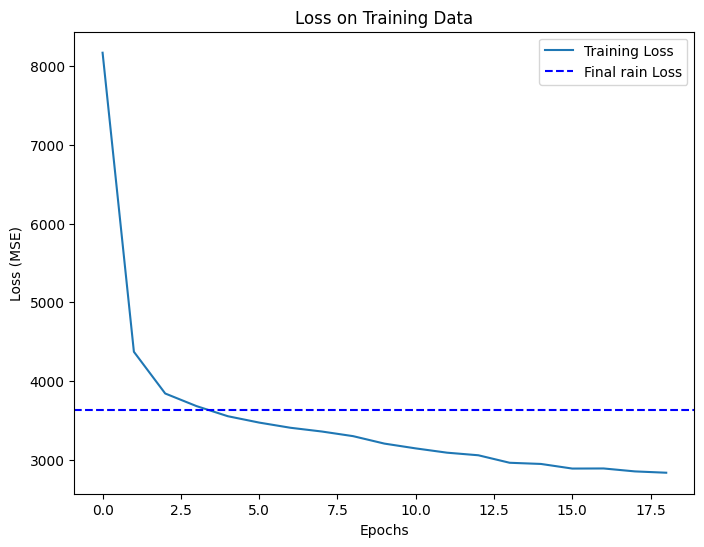

Final Training Loss (MSE): 3635.8843603840814


In [58]:
# Calculate training loss
train_predictions = model.predict(X_train_reshaped)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [59]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test_reshaped, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test_reshaped)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/submission.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
